In [1]:
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import lsst.sims.photUtils as photUtils

In [2]:
fdir = os.getenv('LSST_THROUGHPUTS_DEFAULT')

In [3]:
# Read in the bandpasses.
lsst_hardware = {}
lsst_total = {}
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
components = ['detector.dat', 'lens1.dat', 'lens2.dat', 'lens3.dat', 'm1.dat', 'm2.dat', 'm3.dat']
for f in filterlist:
    lsst_hardware[f] = photUtils.Bandpass()
    comp = components + ['filter_' + f + '.dat']
    lsst_hardware[f].readThroughputList(rootDir=fdir, componentList=comp)
    lsst_total[f] = photUtils.Bandpass()
    # Change atmosphere here if desired. atmos_std.dat will give you X=1.2
    comp = comp + ['atmos_10.dat']
    lsst_total[f].readThroughputList(rootDir=fdir, componentList=comp)

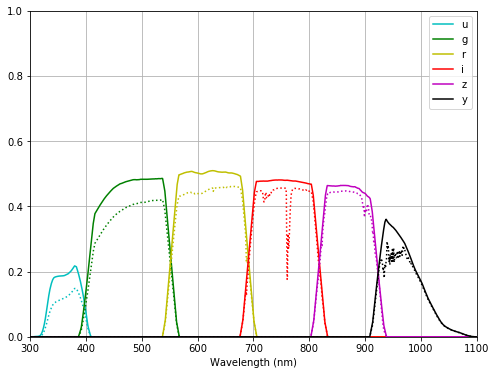

In [4]:
plt.figure(figsize=(8,6))
colors = {'u': 'c', 'g': 'g', 'r': 'y', 'i': 'r', 'z': 'm', 'y': 'k'}
for f in filterlist:
    plt.plot(lsst_hardware[f].wavelen, lsst_hardware[f].sb, color=colors[f], label=f)
    plt.plot(lsst_total[f].wavelen, lsst_total[f].sb, color=colors[f], linestyle=':')
plt.legend(numpoints=1, fancybox=True)
plt.xlabel('Wavelength (nm)')
plt.ylim(0, 1)
plt.xlim(300, 1100)
plt.grid(True)

In [5]:
flatsed = photUtils.Sed()
flatsed.setFlatSED()

In [6]:
darksky = photUtils.Sed()
darksky.readSED_flambda(os.path.join(fdir, 'darksky.dat'))

In [7]:
# Calculate standard limiting magnitude .. setting effarea/readnoise explicitly as these match requirements
# (waiting for PR into photUtils defaults)
effarea = np.pi * (6.423/2.*100.)**2
readnoise = 8.8 # electrons / exposure
nexp = 2 
photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp,  
                                             effarea=effarea, readnoise=readnoise, 
                                             othernoise=0, darkcurrent=0.2)
lsstDefaults = photUtils.LSSTdefaults()
d = pd.DataFrame(index=filterlist, columns=['FWHMeff', 'skybackground', 'm5'])
for i, f in enumerate(filterlist):
    fwhm = lsstDefaults.FWHMeff(f)
    skybackground = darksky.calcMag(lsst_total[f])
    m5 = photUtils.SignalToNoise.calcM5(darksky, lsst_total[f], lsst_hardware[f], photParams, FWHMeff=fwhm)
    d.iloc[i] = [fwhm, skybackground, m5]
print('For %d exposures (%.1f visits)' % (nexp, nexp/2))
d

For 2 exposures (1.0 visits)


,FWHMeff,skybackground,m5
u,0.92,22.9771,23.415
g,0.87,22.2296,24.7675
r,0.83,21.1964,24.342
i,0.8,20.4651,23.8948
z,0.78,19.6034,23.3303
y,0.76,18.615,22.4241


In [8]:
# Calculate limiting magnitude for X exposures
effarea = np.pi * (6.423/2.*100.)**2
readnoise = 8.8
nexp = 100
photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp, 
                                             effarea=effarea, readnoise=readnoise, 
                                             othernoise=0, darkcurrent=0.2)
lsstDefaults = photUtils.LSSTdefaults()
d = pd.DataFrame(index=filterlist, columns=['FWHMeff', 'skybackground', 'm5'])
for i, f in enumerate(filterlist):
    fwhm = lsstDefaults.FWHMeff(f)
    skybackground = darksky.calcMag(lsst_total[f])
    m5 = photUtils.SignalToNoise.calcM5(darksky, lsst_total[f], lsst_hardware[f], photParams, FWHMeff=fwhm)
    d.iloc[i] = [fwhm, skybackground, m5]
print('For %d exposures (%.1f visits)' % (nexp, nexp/2))
d

For 100 exposures (50.0 visits)


,FWHMeff,skybackground,m5
u,0.92,22.9771,25.5623
g,0.87,22.2296,26.9066
r,0.83,21.1964,26.4779
i,0.8,20.4651,26.0295
z,0.78,19.6034,25.4633
y,0.76,18.615,24.5564


In [10]:
# Calculate nexp needed to reach X limiting mag. (set m5goal)
m5goal = {'u': 25.4, 'g': 25.8, 'r': 25.5, 'i': 26, 'z': 26}
effarea = np.pi * (6.423/2.*100.)**2
readnoise = 8.8
# yeah .. this is terribly brute-force. But it's fast enough.
d = pd.DataFrame(index=m5goal.keys(), columns=['m5_goal', 'nexp', 'nvisits', 'm5'])
lsstDefaults = photUtils.LSSTdefaults()
for i, f in enumerate(m5goal):
    fwhm = lsstDefaults.FWHMeff(f)
    nexp = 1
    photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp, 
                                                 effarea=effarea, readnoise=readnoise, 
                                                 othernoise=0, darkcurrent=0.2)
    m5 = photUtils.SignalToNoise.calcM5(darksky, lsst_total[f], lsst_hardware[f], photParams, FWHMeff=fwhm)
    while m5 < m5goal[f]:
        nexp += 1
        photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp, 
                                                     effarea=effarea, readnoise=readnoise, 
                                                     othernoise=0, darkcurrent=0.2)
        m5 = photUtils.SignalToNoise.calcM5(darksky, lsst_total[f], lsst_hardware[f], photParams, FWHMeff=fwhm)
    d.iloc[i] = [m5goal[f], nexp, nexp/2., m5]
print('Number of dark sky, zenith observations needed to reach given limiting magnitude')
d

Number of dark sky, zenith observations needed to reach given limiting magnitude


,m5_goal,nexp,nvisits,m5
u,25.4,75,37.5,25.4055
g,25.8,14,7,25.835
r,25.5,17,8.5,25.5131
i,26,95,47.5,26.0016
z,26,269,134.5,26.0011
